In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
os.chdir("..")
from model import run_experiments
from model.config.params import build_params
import numpy as np

df, simulation_kpis = run_experiments(["gateway_viability_sweep_ag1_1",])


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 365, 65, 1, 27)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (365, 65, 1, 27)
Execution Method: local_simulations
Execution Mode: single_threaded
2023-12-19 14:32:29.995543
Total execution time: 4.20s



In [9]:
simulation_kpis['Experiment Name'].unique()

array(['gateway_viability_sweep_ag1_1', 'gateway_viability_sweep_ag1_2',
       'gateway_viability_sweep_ag1_3'], dtype=object)

## Basic Line Graphs

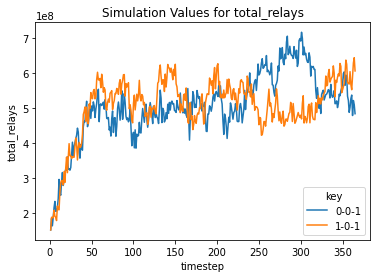

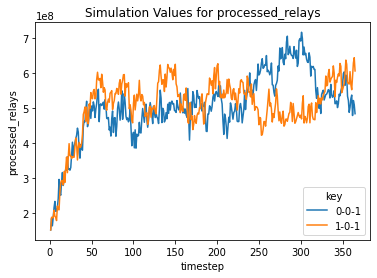

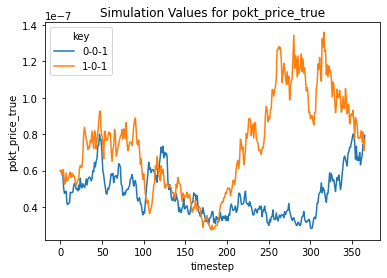

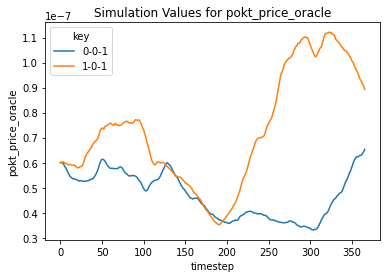

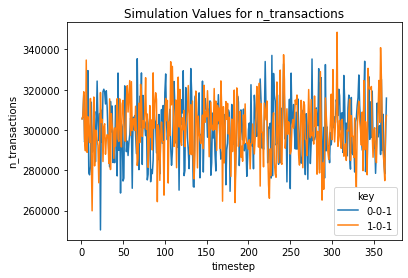

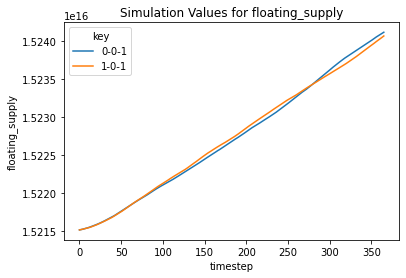

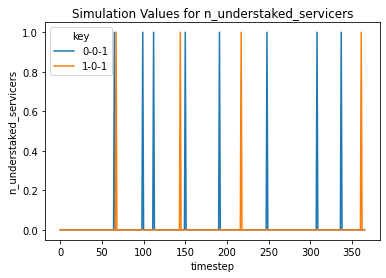

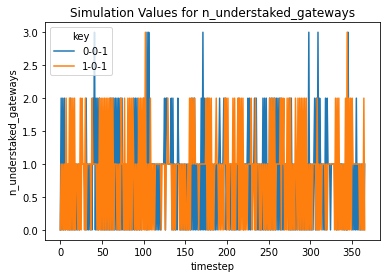

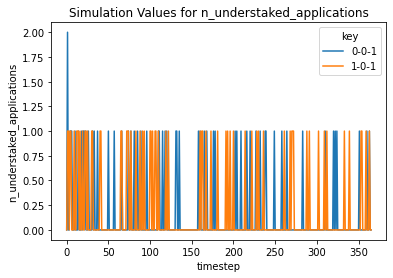

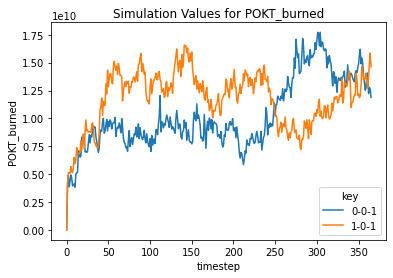

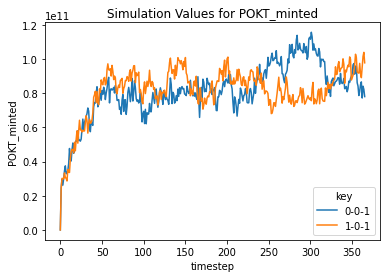

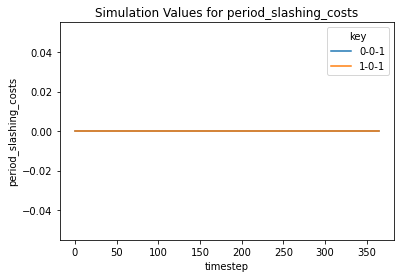

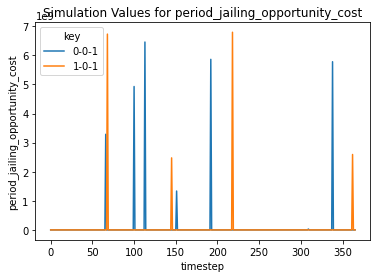

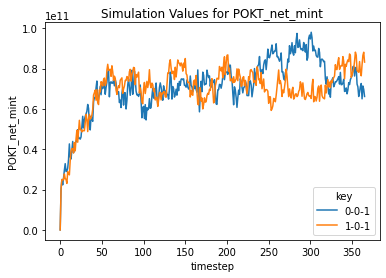

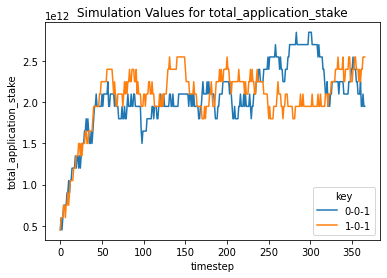

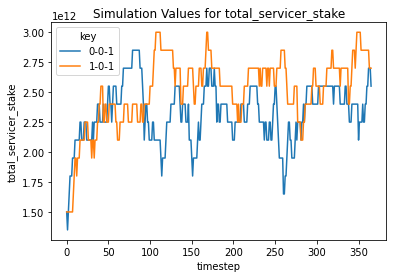

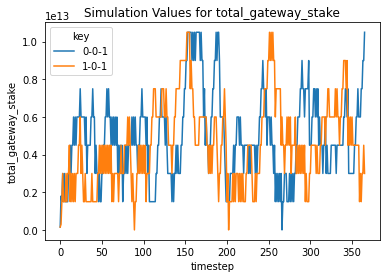

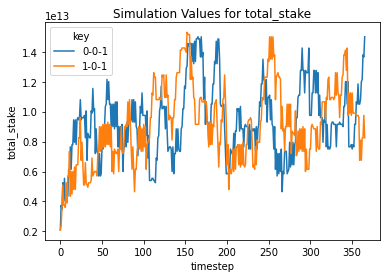

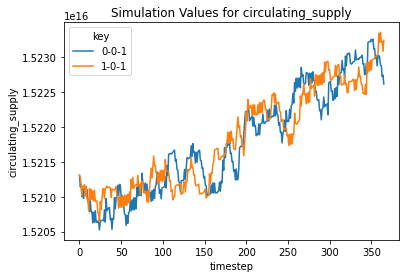

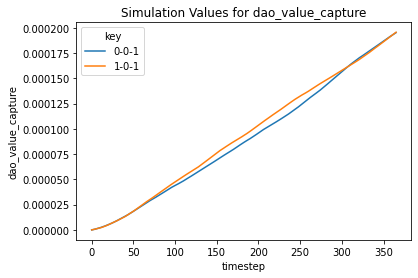

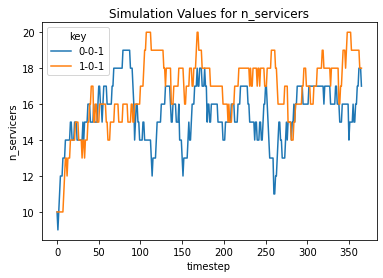

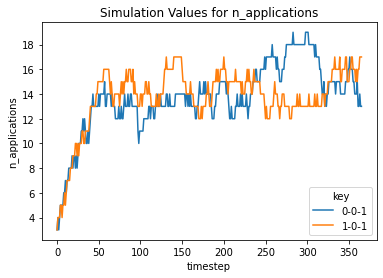

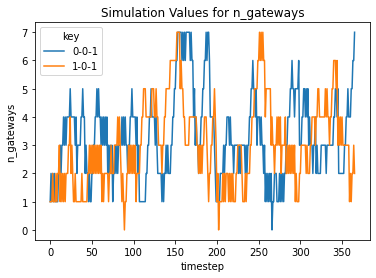

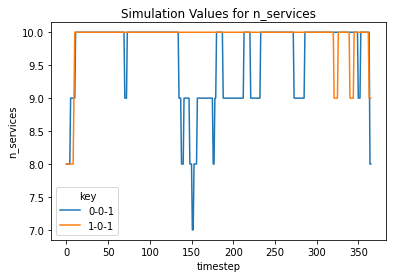

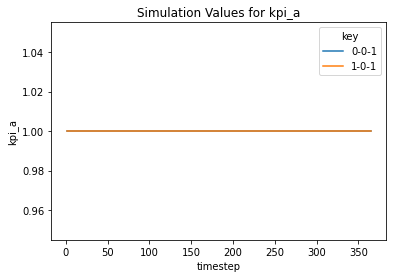

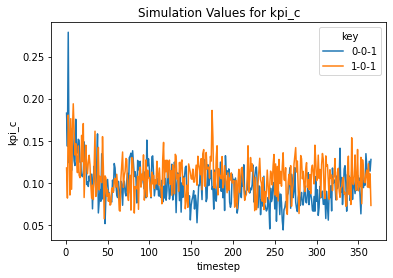

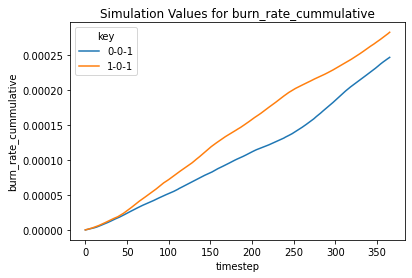

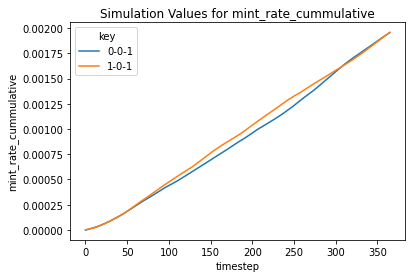

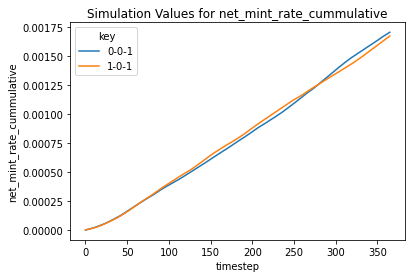

In [2]:
for col in ['total_relays', 'processed_relays', 'pokt_price_true', 'pokt_price_oracle',
           'n_transactions', 'floating_supply', 'n_understaked_servicers', 'n_understaked_gateways',
            'n_understaked_applications', 'POKT_burned', 'POKT_minted','period_slashing_costs',
            'period_jailing_opportunity_cost','POKT_net_mint', 'total_application_stake',
            'total_servicer_stake', 'total_gateway_stake', 'total_stake', 'circulating_supply',
            'dao_value_capture', 'n_servicers', 'n_applications', 'n_gateways',
           'n_services', 'kpi_a', 'kpi_c', 'burn_rate_cummulative',
       'mint_rate_cummulative', 'net_mint_rate_cummulative']:
    # Grab the pivot table
    table = df.pivot("timestep", "key", col)
    
    # Plot
    table.plot(kind = 'line')
    plt.xlabel("timestep")
    plt.ylabel(col)
    plt.title("Simulation Values for {}".format(col))
    
    plt.show()